# Data Collection, Cleaning, and Pre-Processing


## <font color='maroon'>Data Collection</font>


### Imports

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')

### Load Data

<b>Here, we load and combine all of the available Lending Club data, which we downloaded from https://www.lendingclub.com/info/download-data.action. We have included all of the available data from 2007 through 2018Q3, except for the declined loan data.</b>

<b>After loading the data initially using the get_loan_data function, we select only the rows where loan_status is "Charged Off" or "Fully Paid", and then store the data as a .pkl file for faster/easier loading in the future.</b>

In [2]:
def get_loan_data(data_path, other_data_paths=None):
    """Read CSV files containing loan data from specified data path
    and concatenate to one dataframe
    returns: the dataframe"""
    
    if other_data_paths:
        paths = [data_path] + other_data_paths
    else:
        paths = [data_path]

    for path in paths:
        files = files + [join(path,f) for f in listdir(path) if isfile(join(path, f)) and f.endswith ('.csv')]

    #Read CSV and concatenate files into df
    files = []
    df_list = []
    for each in files:
        print('Reading:', each)
        df_list.append(pd.read_csv(each, header=1, skipfooter=2, engine='python'))
        clear_output(wait=True)
    
    df = pd.concat(df_list)

    #Remove any excess rows that do not fit ('id' should always be empty)
    df = df[df['id'].isnull()]        
    
    return df

#loan_df = get_loan_data(data_path='./data/', other_data_paths=['./data/old'])


### Selecting "Fully Paid" and "Charged Off" loans only

<b>Some of the code below has been commented out since we loaded the data from the .pkl after this file was generated and saved.</b>

<b>We see that there are over a million rows in the dataset. For processing purposes, we found that working with a random sample of this large dataset was very useful in the initial stages of data processing.</b>

In [3]:
#msk = loan_df['loan_status'].isin(['Fully Paid', 'Charged Off'])
#loan_df = loan_df[msk]

#cast issue_d column to datetime for later use
#loan_df['issue_d'] = pd.to_datetime(loan_df['issue_d'])

#loan_df.to_pickle('../data/Pickle/loan_df0.pkl')

loan_df = pd.read_pickle('./data/Pickle/loan_df0.pkl').sample(frac=.05, random_state=0)

print('Total Number of Rows:', '{:,}'.format(loan_df.shape[0]))
print('Total Number of Columns:', '{:,}'.format(loan_df.shape[1]))

Total Number of Rows: 57,519
Total Number of Columns: 145


## <font color='maroon'>Data Cleaning</font>


### <font color='maroon'>Missing Values: Visualization and Feature Selection</font>

<b>Checking for and Cleaning Missing Data</b>
<br>A visual check at the data set shows that there are several columns with a large number of null values.

In [4]:
def get_missing_values_table(df):
    #Number of null values by column
    missing_values_df = pd.DataFrame(df.isnull().sum(),columns=['Missing_Count'])
    
    #Portion of null values by column
    missing_values_df['Portion_Missing'] = missing_values_df['Missing_Count']/df.shape[0]

    #Sort by Missing_Count
    missing_values_df = missing_values_df.sort_values(by='Missing_Count',ascending=False)  
    
    return missing_values_df

missing_values_df = get_missing_values_table(loan_df)
missing_values_df.head()

,Missing_Count,Portion_Missing
id,57519,1.000000
next_pymnt_d,57519,1.000000
member_id,57519,1.000000
url,57519,1.000000
orig_projected_additional_accrued_interest,57405,0.998018


Number of Columns with under 15% missing values: 87


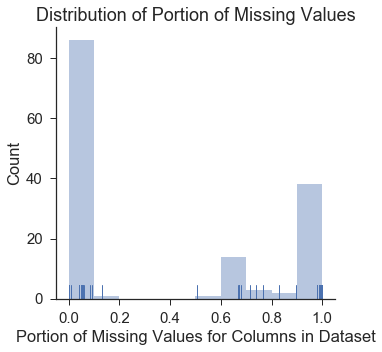

In [5]:
print('Number of Columns with under 15% missing values:', 
      missing_values_df[missing_values_df['Portion_Missing']<=0.15].shape[0])

#Plot the distribution of Portions of missing values for the columns
fig, ax = plt.subplots(figsize=(5,5))
sns.distplot(missing_values_df['Portion_Missing'], bins=10, kde=False, rug=True)
ax.set_title('Distribution of Portion of Missing Values')
ax.set_xlabel('Portion of Missing Values for Columns in Dataset')
ax.set_ylabel('Count')
sns.despine()

Upon first glance, we see that there are many columns that do have a reasonably low level of missingess: 87 columns that have less than 15% missing values.
<br><br>There seems to be a small concentration of columns between 60-70% missing values. Below, we explore this and see that there are 11 columns with almost exactly the same number of missing values. Furthermore, using the `issue_d` column (which indicates the date the date in which the loan was issued), we found that these variables had missing values for all loans issued prior to 2015-12-01. It's possible that the Lending Club simply did not record or use this particular information from potential borrowers until a later date. We have chosen not to include these columns because:

1) there are many other columns that capture similar credit-related information; and 

2) we want to keep the older loan information in the dataset, especially since we are looking at only completed loans. Removing the older samples would greatly reduce our sample size.


In [6]:
missing_grp = missing_values_df[(missing_values_df['Portion_Missing']>=0.6)&(missing_values_df['Portion_Missing']<=0.7)]
display(missing_grp)

missing_columns = missing_grp.index

earliest_date = []
for column in missing_columns:
    earliest_date.append(min(loan_df[~loan_df[column].isnull()]['issue_d'])) 

display(pd.DataFrame({'Column':missing_columns,
                      'Earliest issue_d for which column value is not null':earliest_date}))


,Missing_Count,Portion_Missing
mths_since_rcnt_il,39066,0.679184
all_util,38578,0.670700
inq_fi,38576,0.670665
total_bal_il,38576,0.670665
open_il_24m,38576,0.670665
open_il_12m,38576,0.670665
open_act_il,38576,0.670665
open_acc_6m,38576,0.670665
open_rv_24m,38576,0.670665
max_bal_bc,38576,0.670665


,Column,Earliest issue_d for which column value is not null
0,mths_since_rcnt_il,2015-12-01
1,all_util,2015-12-01
2,inq_fi,2015-12-01
3,total_bal_il,2015-12-01
4,open_il_24m,2015-12-01
5,open_il_12m,2015-12-01
6,open_act_il,2015-12-01
7,open_acc_6m,2015-12-01
8,open_rv_24m,2015-12-01
9,max_bal_bc,2015-12-01


**Before going on, we will remove many columns from the dataset. We have made decisions on which columns to initially drop from our DataFrame based on the variable descriptions in the Lending Club data dictionary, applicability of each feature to our model, and the level of missingness observed.:**

*   There are 3 columns relating to the lending club's borrower identification (`id`, `member_id`, and `url`), which contain 100% missing values. `next_pymnt_d` also has all missing values: since these loans have been completed, there is no data for the next payment date. We exclude these four columns.

*   `pymnt_plan`, `out_prncp`, `out_prncp_inv`, and `policy_code` have only one unique value each so they will not be useful in our model. We exclude these columns.

*   As we saw above following columns all had the same large number of missing values, and we determined that all of the loans issued prior to December 2015 have null values for these variables. This could be because the lending club did not previously store/analyze these columns but made a recent change. We have chosen to drop these variables since other variables cover similar information and we prefer to keep as many of the samples as possible. The 11 columns are:
`open_acc_6m`, `open_act_il`, `open_il_12m`, `open_il_24m`, `total_bal_il`, `open_rv_12m`, `open_rv_24m`, `max_bal_bc`, `inq_fi`, `total_cu_tl`, `inq_last_12m`. The following 3 columns had slightly more missing data but followed the same trend of newer-only data, so we also exclude them: `il_util`, `all_util`, `mths_since_rcnt_il`

*  We exclude `num_tl_120dpd_2m` and `num_tl_30dpd` because data dictionary indicates these were "udpated in past 2 months" (i.e. we wouldn't have these values at loan origination)

*   Hardship-related variables: There are a number of columns relating to borrowers who were on a hardship plan. For borrowers who were not on a hardship plan, the data are coded as missing. We will remove these variables, since we do not know at the point of loan origination whether or not the borrower will have a hardship. This is the list of hardshp-related columns based on the data dictionary: `deferral_term`,`hardship_amount`,`hardship_dpd`, `hardship_end_date`, `hardship_flag`, `hardship_last_payment_amount`, `hardship_length`, `hardship_loan_status`, `hardship_payoff_balance_amount`, `hardship_reason`, `hardship_start_date`, `hardship_status`, `hardship_type`, `orig_projected_additional_accrued_interest`, `payment_plan_start_date`.

*  We exclude `desc`,  `title` and `emp_title` because these are string variables with borrower-provided text; the Lending Club has categorized this information in other columns.

*  We exclude columns related to the specifics of loan settlement, something we wouldn't know at the time of funding (and in our case these are very trivial features relating to a loan being charged off): `debt_settlement_flag`, `debt_settlement_flag_date`,`settlement_amount`, `settlement_date`, `settlement_percentage`, `settlement_status`, `settlement_term`, `recoveries`, `collection_recovery_fee`

*  We also excluded the following colums since they include information relating to the specifics of the Lending Club's loan (including information on late fees received on the lending club loan, last payment amount on the lending club loan, etc.), which also wouldn't be available at the time of the funding decision: `funded_amnt`, `funded_amnt_inv`, `last_pymnt_amnt`, `out_prncp`, `out_prncp_inv`,  `total_pymnt`, `total_pymnt_inv`, `total_rec_int`, `total_rec_late_fee`, `total_rec_prncp`, `last_pymnt_d`,  `last_credit_pull_d`, `disbursement_method`
 
*  We exclude `initial_list_status` based on research into the meaning of this column.  "On September 28th, 2012, LendingClub announced that, as opposed to its standard fractional investment business model, it would begin setting aside some loans that could only be purchased in their entirety–or as whole loans. Part of that announcement were promises that whole loans would be chosen randomly from the general pool and that anyone would be able to participate in the whole loan program"(https://www.lendacademy.com/lending-club-whole-loan-program-one-year-later/). Because the whole loans are randomly-chosen, they should not provide additional information. Also, we noticed that there are more "whole"-category loans in later years.

**Text descriptions of the variables that remain in our model after cleaning are provided at the end of this page.**

In [7]:
exclude = ['id', 'member_id', 'url', 'next_pymnt_d', 'pymnt_plan', 'out_prncp',
           'out_prncp_inv', 'policy_code', 'open_acc_6m', 'open_act_il', 'open_il_12m',
           'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
           'inq_fi', 'total_cu_tl', 'inq_last_12m', 'il_util', 'all_util','mths_since_rcnt_il',
           'num_tl_120dpd_2m', 'num_tl_30dpd', 'deferral_term', 'hardship_amount',
           'hardship_dpd', 'hardship_end_date', 'hardship_flag', 'hardship_last_payment_amount',
           'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount',
           'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type',
           'orig_projected_additional_accrued_interest', 'payment_plan_start_date',
           'desc', 'title', 'emp_title', 'debt_settlement_flag', 'debt_settlement_flag_date',
           'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status',
           'settlement_term', 'recoveries', 'collection_recovery_fee', 'funded_amnt',
           'funded_amnt_inv', 'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',  'total_pymnt',
           'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
           'last_pymnt_d',  'last_credit_pull_d', 'disbursement_method', 'initial_list_status' ]

potential_features = np.setdiff1d(loan_df.columns.tolist(), exclude)

print(len(potential_features))
print(sorted(potential_features))

loan_df = loan_df[potential_features]

82
['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'annual_inc_joint', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'dti_joint', 'earliest_cr_line', 'emp_length', 'grade', 'home_ownership', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankrupt

**We visualize missingness on the remaining columns and see that many of the columns are new from 2012-08-01 and later. We choose to work with data from this date and beyond since the data from prior to this date is only a small subset of our data.**

In [8]:
def view_missingness_by_issue_d(df):
    missing_values_df = get_missing_values_table(df)
    earliest_date = []
    cols_with_missing_vals = missing_values_df[(missing_values_df.Portion_Missing<1) &
                                           (missing_values_df.Missing_Count >0)].index

    for column in cols_with_missing_vals:
        earliest_date.append(min(loan_df[~loan_df[column].isnull()]['issue_d'])) 

    df = pd.DataFrame({'Column':cols_with_missing_vals,
                      'Earliest issue_d for which column value is not null':earliest_date})
    
    return df.sort_values(by='Earliest issue_d for which column value is not null', ascending=False)

view_missingness_by_issue_d(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
0,sec_app_mths_since_last_major_derog,2017-03-01
2,sec_app_inq_last_6mths,2017-03-01
3,sec_app_earliest_cr_line,2017-03-01
4,sec_app_collections_12_mths_ex_med,2017-03-01
5,sec_app_chargeoff_within_12_mths,2017-03-01
6,revol_bal_joint,2017-03-01
7,sec_app_num_rev_accts,2017-03-01
8,sec_app_open_acc,2017-03-01
9,sec_app_open_act_il,2017-03-01
10,sec_app_mort_acc,2017-03-01


Now, we see that there are columns relating to details of applications that have multiple borrowers (co-borrowers). These columns only have non-null values from issue dates of 2017-03-01 and later (or 2015-10-01 and later for 'dti_joint', 'annual_inc_joint', and 'verification_status_joint'), so we remove these columns. We remove all of these columns: 

`annual_inc_joint`, `dti_joint`, `revol_bal_joint`, `sec_app_chargeoff_within_12_mths`, `sec_app_collections_12_mths_ex_med`, `sec_app_earliest_cr_line`, `sec_app_inq_last_6mths`, `sec_app_mort_acc`, `sec_app_mths_since_last_major_derog`, `sec_app_num_rev_accts`, `sec_app_open_acc`, `sec_app_open_act_il`, `sec_app_revol_util`, `verification_status_joint`]

Note that we still do have the `application_type` variable, which is a simple binary indicator of whether or not the application had co-borrowers.

In [9]:
coborrower_cols =  ['annual_inc_joint', 'dti_joint', 'revol_bal_joint',
                    'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',
                    'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
                    'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts',
                    'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
                    'verification_status_joint']

potential_features = np.setdiff1d(loan_df.columns.tolist(), coborrower_cols)
loan_df = loan_df[potential_features]

**After removing these colummns, we take another look at the remaining columns that have missing values.**

In [10]:
display(view_missingness_by_issue_d(loan_df))

get_missing_values_table(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
22,total_rev_hi_lim,2012-08-01
14,num_il_tl,2012-08-01
26,tot_cur_bal,2012-08-01
25,tot_coll_amt,2012-08-01
24,tot_hi_cred_lim,2012-08-01
23,total_il_high_credit_limit,2012-08-01
1,mths_since_recent_bc_dlq,2012-08-01
21,mo_sin_rcnt_rev_tl_op,2012-08-01
20,mo_sin_old_rev_tl_op,2012-08-01
18,num_tl_90g_dpd_24m,2012-08-01


,Missing_Count,Portion_Missing
mths_since_last_record,47647,0.828370
mths_since_recent_bc_dlq,43972,0.764478
mths_since_last_major_derog,42490,0.738712
mths_since_recent_revol_delinq,38378,0.667223
mths_since_last_delinq,29089,0.505729
mths_since_recent_inq,7657,0.133121
mo_sin_old_il_acct,4930,0.085711
pct_tl_nvr_dlq,3351,0.058259
avg_cur_bal,3346,0.058172
num_actv_bc_tl,3344,0.058137


**We notice that many of the columns only have non-null values for issue dates of 2012-08-01 and later, so we remove the samples that have issue_dates prior to this. We see that this only reduces our sample size by a small amount.**

In [11]:
print("Number of rows in dataset: {}".format (loan_df.shape[0]))

# removing data from loans issued prior to 2012-08-01
loan_df = loan_df[loan_df['issue_d']>=datetime(2012,8,1)]


print("Number of rows in dataset after removing loans issued prior to 2012-08-01: {}"\
      .format (loan_df.shape[0]))


Number of rows in dataset: 57519
Number of rows in dataset after removing loans issued prior to 2012-08-01: 54383


**Taking another look at missingness: **

In [12]:
display(view_missingness_by_issue_d(loan_df))

get_missing_values_table(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
0,mths_since_last_record,2012-08-01
25,num_op_rev_tl,2012-08-01
19,mo_sin_rcnt_rev_tl_op,2012-08-01
20,mo_sin_old_rev_tl_op,2012-08-01
21,num_tl_op_past_12m,2012-08-01
22,num_tl_90g_dpd_24m,2012-08-01
23,num_accts_ever_120_pd,2012-08-01
24,num_il_tl,2012-08-01
26,num_rev_accts,2012-08-01
1,mths_since_recent_bc_dlq,2012-08-01


,Missing_Count,Portion_Missing
mths_since_last_record,44691,0.821783
mths_since_recent_bc_dlq,40836,0.750896
mths_since_last_major_derog,39354,0.723645
mths_since_recent_revol_delinq,35455,0.651950
mths_since_last_delinq,27073,0.497821
mths_since_recent_inq,5205,0.095710
emp_length,3093,0.056874
mo_sin_old_il_acct,1794,0.032988
bc_util,624,0.011474
percent_bc_gt_75,616,0.011327


### <font color='maroon'>Pre-Processing of Selected Columns</font>

**Great! The missingness for the remaining columns is much more reasonable, but there are still a few columns with large portions of missing values. Consulting the data dictionary reveals a plausible explanation for this:**

**Many of the columns that still have high levels of missingness are those which measure "months since" something happened. For example, `months_since_recent_bc_dlq` measures "Months since most recent bankcard delinquency." Thus, it's likely that the "missing" values are not truly missing data; rather, the borrower has simply never had a bankcard delinquency. Thus, we choose to process the "month since" columns by filling the null values with the maximum observed value + 1, so that the borrowers who have never had delinquencies just have the largest value for number of months since delinquency. Since we will be using decision-tree based models, this is an appropriate approach that allows the decision tree to separate the borrowers who have had recent delinquencies from those who have not.**

**We also process a few other columns below:**
- Re-categorize emp_length so that there are fewer categories
- Cast `revol_util` to float
- Change `loan_grade` and `grade` values to numerical rankings (i.e., an ordinal variable with the lowest grade/subgrade indicating the least-risky loans)
- `credit_line_age` and `earliest_cr_line`
- `int_rate`
- `zip_code`
- `fully_paid` and `loan_status`


In [13]:
#emp_length
print('emp_length value counts: \n{}\n'.format(loan_df.emp_length.value_counts()))

emp_length value counts: 
10+ years    18067
2 years       4761
3 years       4403
< 1 year      4235
1 year        3537
5 years       3328
4 years       3255
8 years       2554
6 years       2554
7 years       2472
9 years       2124
Name: emp_length, dtype: int64



In [14]:
def process_emp_length(df):
    df_new = df.copy()
    #0-1 years inclues: null, None, < 1 year, 1 year
    df_new['emp_length'] = df_new['emp_length'].fillna('0-1 years')
    df_new['emp_length'] = np.where(df_new['emp_length'].isin([np.nan,None,'< 1 year','1 year']),
                                     '0-1 years',df_new['emp_length'])
    #2-4 years inclues: 2 years, 3 years, 4 years
    df_new['emp_length'] = np.where(df_new['emp_length'].isin(['2 years','3 years','4 years']),
                                     '2-4 years',df_new['emp_length'])
    
    #5-9 years inclues: 5 years, 6 years, 7 years, 8 years, 9 years
    df_new['emp_length'] = np.where(df_new['emp_length'].isin(['5 years','6 years','7 years','8 years','9 years']),
                                     '5-9 years',df_new['emp_length'])
    #10+ years includes 10+ years (no change)
    return df_new

def process_revol_util(df):
    df_new = df.copy()
    
    df_new['revol_util'] = df_new['revol_util'].fillna(-100)
    df_new['revol_util'] = df_new['revol_util'].apply(lambda x: float(str(x).split('%')[0])/100)
    df_new['revol_util'] = np.where(df_new['revol_util']==-1.0,np.nan,df_new['revol_util'])
    
    return df_new

def process_month_since_cols(df):
    df_new = df.copy()

    mo_since_cols = ['mo_sin_old_il_acct','mths_since_last_delinq','mths_since_last_major_derog',
                     'mths_since_last_record','mths_since_recent_bc_dlq','mths_since_recent_inq',
                     'mths_since_recent_revol_delinq','mo_sin_old_rev_tl_op','mths_since_recent_bc',
                     'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl']

    for col in mo_since_cols:
        df_new[col].fillna(df_new[col].max()+1, inplace=True)
    
    return df_new

def process_loan_grades(df):
    df_new = df.copy()
    
    # turn sub_grade into ordinal mapping
    sorted_subgrades = sorted(df.sub_grade.unique())
    subgrade_dict = dict(zip(sorted_subgrades, range(len(sorted_subgrades))))
    df_new['sub_grade'] = df_new['sub_grade'].map(subgrade_dict)
    
    # turn grade into ordinal mapping
    sorted_grades = sorted(df.grade.unique())
    grade_dict = dict(zip(sorted_grades, range(len(sorted_grades))))
    df_new['grade'] = df_new['grade'].map(grade_dict)
    return df_new
    
    
def process_loan_cols(df):
    df_processed = process_emp_length(df)
    df_processed = process_revol_util(df_processed)
    df_processed = process_month_since_cols(df_processed)
    df_processed = process_loan_grades(df_processed)
    
    #add credit_line_age
    df_processed['credit_line_age'] = df_processed['issue_d'] - pd.to_datetime(df_processed['earliest_cr_line'])
    df_processed = df_processed.drop(columns='earliest_cr_line')

    #process int_rate, zip_code, credit_line_age
    df_processed['int_rate'] = df_processed['int_rate'].apply(lambda x: float(str(x).split('%')[0])/100)
    df_processed['zip_code'] = df_processed['zip_code'].apply(lambda x: x[:3])
    df_processed['credit_line_age'] = df_processed['credit_line_age'].apply(lambda x: x.days)
    
    # generate new column for outcome variable ('fully_paid'); drop 'loan_status'
    df_processed['fully_paid'] = df_processed['loan_status'].map({'Fully Paid':1, 'Charged Off':0})
    df_processed = df_processed.drop(columns='loan_status')
    
    return df_processed

loan_df = process_loan_cols(loan_df)

### <font color='maroon'>Missing Values: Imputation for Continuous Columns</font>


**We will fill the remaining columns' missing values using linear regression model-based imputation. First, we verify that all of the remaining columns are continuous float-64 variables for which this model imputation is appropriate.**

**Then, we use pd.get_dummies() to get dummy-variables for the necessary categorical columns. This is an important step which should be done prior to model-based imputation**

**Finally, we proceed with our imputation.**

In [15]:
# check which cols still have missing values
missing_data = get_missing_values_table(loan_df)
display(missing_data[missing_data.Missing_Count!=0])
missing_cols = missing_data[missing_data.Missing_Count!=0].index

print("datatypes of the columns that still have missing values: ")
print(loan_df[missing_cols].dtypes.unique().tolist())

,Missing_Count,Portion_Missing
bc_util,624,0.011474
percent_bc_gt_75,616,0.011327
bc_open_to_buy,602,0.011070
pct_tl_nvr_dlq,215,0.003953
avg_cur_bal,210,0.003862
num_actv_bc_tl,208,0.003825
tot_coll_amt,208,0.003825
num_actv_rev_tl,208,0.003825
num_op_rev_tl,208,0.003825
num_accts_ever_120_pd,208,0.003825


datatypes of the columns that still have missing values: 
[dtype('float64')]


**Before performing imputation, we need to process some of the categorical variables using pd.get_dummies. We do so below.**

In [16]:
#Rerun Types
types_df = pd.DataFrame(loan_df.dtypes,columns=['Types'])
display(types_df[types_df['Types']!='float64'].sort_values(by='Types'))


# get list of variables that need dummy encoding
object_vars=loan_df.select_dtypes(include='object').columns.tolist()
object_vars = np.setdiff1d(object_vars,['addr_state', 'zip_code'])
print(object_vars)

#Dummy encoding
loan_df = pd.get_dummies(loan_df,columns=object_vars,drop_first=True) 


,Types
grade,int64
issue_d,datetime64[ns]
sub_grade,int64
credit_line_age,int64
fully_paid,int64
addr_state,object
application_type,object
emp_length,object
home_ownership,object
purpose,object


['application_type' 'emp_length' 'home_ownership' 'purpose' 'term'
 'verification_status']


In [17]:
#columns where imputation is neededpd.
missing_cols = loan_df.columns[loan_df.isnull().any()].tolist()

#verify they're all continuous dtypes appropriate for linear regression imputation
loan_df[missing_cols].dtypes.unique() # all float64

array([dtype('float64')], dtype=object)

**Performing the Linear Regression Model-Based Imputation:**

In [18]:
def impute_missing_continuous(df, missing_columns, cols_to_exclude):
    clean_df = df.copy()
    
    for column in missing_columns:
        types_df = pd.DataFrame(df.dtypes,columns=['Types'])
        # Remove response variable
        impute_train = clean_df[~clean_df[column].isnull()].drop(cols_to_exclude,1).sample(frac=0.1,random_state=12)

        #Split target
        X_impute_train = impute_train.drop(column,1)
        Y_impute_train = impute_train[column]

        #Mean Imputation for current nulls for columns that did not get imputed yet
        X_impute_train = X_impute_train.fillna(X_impute_train.mean())

        # Train LinearRegression
        impute_ols = LinearRegression(fit_intercept=True)
        impute_ols.fit(X_impute_train,Y_impute_train)

        # Generate new temp column with model predictions
        # Only replace rows where the value is null with the K-NN predicted value 
        predictions = clean_df.drop(cols_to_exclude + [column],1)

        #Mean Imputation for current nulls for columns that did not get imputed yet
        predictions = predictions.fillna(predictions.mean())
        clean_df['temp'] = impute_ols.predict(predictions)

        clean_df[column] = np.where(clean_df[column].isnull(),clean_df['temp'],clean_df[column])
        clean_df = clean_df.drop('temp',1)
    
    return clean_df

clean_df = impute_missing_continuous(loan_df, missing_columns=missing_cols, cols_to_exclude=['fully_paid','issue_d', 'zip_code', 'addr_state'])

In [19]:
# verify that we no longer have null values
clean_df.isnull().values.any()

False

In [20]:
print("float64 columns: ")
print(clean_df.dtypes[clean_df.dtypes=='float64'].index.tolist())

print("\nnon-float64 columns: ")
print(clean_df.dtypes[clean_df.dtypes!='float64'])

print("\n\nVisualizing unique values for non-float64 variables (except for zip_code and issue_d)")
for col in clean_df.dtypes[clean_df.dtypes!='float64'].index.tolist():
    if not col in['issue_d', 'zip_code']:
        print("\n", col)
        print(clean_df[col].unique())


float64 columns: 
['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_b

In [21]:
clean_df.to_pickle('./data/Pickle/clean_df_5pct_subset.pkl')

## <font color='maroon'>Generating clean_df For Entire Dataset</font>

Since we worked on a subset above, we redo our cleaning on the full dataset and save the clean_df as a .pkl file.

In [22]:
loan_df = pd.read_pickle('./data/Pickle/loan_df0.pkl')

# this includes co-borrower columns
exclude = ['id', 'member_id', 'url', 'next_pymnt_d', 'pymnt_plan', 'out_prncp',
           'out_prncp_inv', 'policy_code', 'open_acc_6m', 'open_act_il', 'open_il_12m',
           'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
           'inq_fi', 'total_cu_tl', 'inq_last_12m', 'il_util', 'all_util','mths_since_rcnt_il',
           'num_tl_120dpd_2m', 'num_tl_30dpd', 'deferral_term', 'hardship_amount',
           'hardship_dpd', 'hardship_end_date', 'hardship_flag', 'hardship_last_payment_amount',
           'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount',
           'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type',
           'orig_projected_additional_accrued_interest', 'payment_plan_start_date',
           'desc', 'title', 'emp_title', 'debt_settlement_flag', 'debt_settlement_flag_date',
           'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status',
           'settlement_term', 'recoveries', 'collection_recovery_fee', 'funded_amnt',
           'funded_amnt_inv', 'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',  'total_pymnt',
           'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
           'last_pymnt_d',  'last_credit_pull_d', 'disbursement_method', 'initial_list_status',
           'annual_inc_joint', 'dti_joint', 'revol_bal_joint','sec_app_chargeoff_within_12_mths',
           'sec_app_collections_12_mths_ex_med','sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
           'sec_app_mort_acc','sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts',
           'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
           'verification_status_joint']

# remove above columns
potential_features = np.setdiff1d(loan_df.columns.tolist(), exclude)
loan_df = loan_df[potential_features]

# removing data from loans issued prior to 2012-08-01
loan_df = loan_df[loan_df['issue_d']>=datetime(2012,8,1)]

# process the columns that we identified as needing to be pre-processed
loan_df = process_loan_cols(loan_df)

# dummy-encoding for certain columns
object_vars = loan_df.select_dtypes(include='object').columns.tolist()
vars_for_dummies = np.setdiff1d(object_vars,['addr_state', 'zip_code'])

# save the original columns before getting dummies
tmp_df = loan_df[vars_for_dummies]
loan_df = pd.get_dummies(loan_df,columns=vars_for_dummies,drop_first=True) 

# impute data for remaining columns that still have missingness
missing_cols = loan_df.columns[loan_df.isnull().any()].tolist()

clean_df = impute_missing_continuous(loan_df, missing_columns=missing_cols,
                                     cols_to_exclude=['fully_paid','issue_d', 'zip_code', 'addr_state'])

# add original (non-dummy) columns back for easy visualization in EDA (they will be removed prior to model training)
for col in vars_for_dummies:
    clean_df[col] = tmp_df[col]
    
print(sorted(clean_df.columns.tolist()))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'application_type_Joint App', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'credit_line_age', 'delinq_2yrs', 'delinq_amnt', 'dti', 'emp_length', 'emp_length_10+ years', 'emp_length_2-4 years', 'emp_length_5-9 years', 'fully_paid', 'grade', 'home_ownership', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_

In [27]:
print(clean_df.shape)
#print(vars_for_dummies)

(1087436, 93)


In [26]:
# save as pkl
clean_df.to_pickle('./data/Pickle/clean_df_for_eda.pkl')


## <font color='maroon'>Descriptions of Variable Meanings (Data Dictionary)</font>


Descriptions of the remaining variables are provided below. Except for a few variables which we have processed/engieneered, descriptions are taken from the data dictionary which can be downloaded from the lending club website:

`acc_now_delinq`: The number of accounts on which the borrower is now delinquent.

`acc_open_past_24mths`: Number of trades opened in past 24 months.

`addr_state`: The state provided by the borrower in the loan application
<br>We have kept this as a string variable for the time being. It will need to be further processed if we want to include it in our model (using pd.get_dummies). We keep it in the dataset in this form for the time being so that we can compare loans by state.

`annual_inc`: the borrower's self-reported annual income.

`application_type`: Indicates whether the loan is an individual application or a joint application with two co-borrowers. We used pd.get_dummies to change this into a binary 0/1 categorical variable.

`avg_cur_bal`: Average current balance of all accounts

`bc_open_to_buy`: Total open to buy on revolving bankcards.

`bc_util`: Ratio of total current balance to high credit/credit limit for all bankcard accounts.

`chargeoff_within_12_mths`: Number of charge-offs within 12 months

`collections_12_mths_ex_med`: Number of collections in 12 months excluding medical collections

`credit_line_age`: Number of days between `earliest_cr_line` and `issue_d` (i.e., age in days of the borrower's credit line at the issue date). This column was not in the original dataset; we engineered it.

`delinq_2yrs`: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

`delinq_amnt`: The past-due amount owed for the accounts on which the borrower is now delinquent.

`dti`: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

*`earliest_cr_line`: The month the borrower's earliest reported credit line was opened
<br>After we used this variable to calculate `credit_line_age`, we removed it.

`emp_length` - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
<br>We were unable to change this to a continuous variable but we reduced the number of categorical bins to help reduce potential overfitting (and to create categorical bins with similar numbers of samples within each bin). We will treated nulls as 0 years worked as they most often appear when no 'emp_title' was listed.

`grade`: LC assigned loan grade
<br>We processed this to make it an ordinal variable, with lower values indicating less-risky loans. 

`home_ownership`: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
<br>We simply used pd.get_dummies to process this column.

`inq_last_6mths`: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

`installment`: The monthly payment owed by the borrower if the loan originates.

`int_rate`: Interest Rate on the loan
<br>Originally this was a string percent (%). We processed it to cast it to a float.

`issue_d`: The date in which the loan was issued.
While we will not be using <b>issue_d</b> as a feature in the model itself, we will not remove it at this point in case we need to sample or sort by date. This will be removed later before model training.

`loan_amnt`: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

`loan_status`: Current status of the loan

`mo_sin_old_il_acct`: Months since oldest bank installment account opened. We filled missing values with (maximum observed value+1)

`mo_sin_old_rev_tl_op`: Months since oldest bank installment account opened. We filled missing values with (maximum observed value+1)

`mo_sin_rcnt_rev_tl_op`: Months since most recent revolving account opened. We filled missing values with (maximum observed value+1)

`mo_sin_rcnt_tl`: Months since most recent account opened. We filled missing values with (maximum observed value+1)

`mort_acc`: Number of mortgage accounts.

`mths_since_last_delinq`: The number of months since the borrower's last delinquency. We filled missing values with (maximum observed value+1)

`mths_since_last_major_derog`: Months since most recent 90-day or worse rating. We filled missing values with (maximum observed value+1)

`mths_since_last_record`: The number of months since the last public record. We filled missing values with (maximum observed value+1)

`mths_since_recent_bc`: Months since most recent bankcard account opened. We filled missing values with (maximum observed value+1)

`mths_since_recent_bc_dlq`: Months since most recent bankcard delinquency. We filled missing values with (maximum observed value+1)

`mths_since_recent_inq`: Months since most recent inquiry. We filled missing values with (maximum observed value+1)

`mths_since_recent_revol_delinq`: Months since most recent revolving delinquency. We filled missing values with (maximum observed value+1)

`num_accts_ever_120_pd`: Number of accounts ever 120 or more days past due

`num_actv_bc_tl`: Number of currently active bankcard accounts

`num_actv_rev_tl`: Number of currently active revolving trades

`num_bc_sats`: Number of satisfactory bankcard accounts

`num_bc_tl`: Number of bankcard accounts

`num_il_tl`: Number of installment accounts

`num_op_rev_tl`: Number of open revolving accounts

`num_rev_accts`: Number of revolving accounts

`num_rev_tl_bal_gt_0`: Number of revolving trades with balance >0

`num_sats`: Number of satisfactory accounts

`num_tl_90g_dpd_24m`: Number of accounts 90 or more days past due in last 24 months

`num_tl_op_past_12m`: Number of accounts opened in past 12 months

`open_acc`: The number of open credit lines in the borrower's credit file.

`pct_tl_nvr_dlq`: Percent of trades never delinquent

`percent_bc_gt_75`: Percentage of all bankcard accounts > 75% of limit.

`pub_rec`: Number of derogatory public records

`pub_rec_bankruptcies`: Number of public record bankruptcies

`purpose`: a neatly-categorized variable describing the purpose of the loan.
We simply used pd.get_dummies to process this variable.

`revol_bal`: Total credit revolving balance

`revol_util`: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
<br> We not that this variable was originally a string percent (%). We processed this variable to cast it to float. (While processing, we temporarily set nulls as -1 to cast the column to float.)

`sub_grade` - LC assigned loan subgrade
<br>We processed this to make it an ordinal variable, with lower values indicating less-risky loans. 

`tax_liens`: Number of tax liens

`term`: The number of payments on the loan. Values are in months and can be either 36 or 60.
<br>We simply used pd.get_dummies to process this column.

`tot_coll_amt`: Total collection amounts ever owed

`tot_cur_bal`: Total current balance of all accounts

`tot_hi_cred_lim`: Total high credit/credit limit

`total_acc`: The total number of credit lines currently in the borrower's credit file

`total_bal_ex_mort`: Total credit balance excluding mortgage

`total_bc_limit`: Total bankcard high credit/credit limit

`total_il_high_credit_limit`: Total installment high credit/credit limit

`total_rev_hi_lim`: Total revolving high credit/credit limit

`verification_status`: Indicates if income was verified by LC, not verified, or if the income source was verified.
<br>We simply used pd.get_dummies to process this column.

`zip_code` - The first 3 numbers of the zip code provided by the borrower in the loan application. While our model will not be trained directly on the zip_code, we will keep this in the dataset as we will be using it to assess fairness of the model going forward.

--------